# PLINDER validation/test set

In [1]:
import os

import plinder.core.utils.config

cfg = plinder.core.get_config()

# print(f"local cache directory: {cfg.data.plinder_dir}")
print(f"remote data directory: {cfg.data.plinder_remote}")  # noqa: T201

remote data directory: gs://plinder/2024-06/v2


Use PLINDER package to access the index file.

```python

from plinder.core.scores import query_index

# Get system_id, entry_pdb_id, and split columns of train and val splits
df_index = query_index(
    columns=[
        "system_id",
        "entry_pdb_id",
        "system_num_ligand_chains",
        "system_num_protein_chains",
        "ligand_instance_chain",
    ],
    splits=["val"],
    # splits = ["test"],
)
```

In [2]:
# Save the DataFrame to a CSV file
# splits: val
# df.to_csv("plinder_val_systems.csv", index=False)

# splits: test
# df.to_csv("plinder_test_systems.csv", index=False)

In [3]:
import pandas as pd

# Load index of validation systems
df_index = pd.read_csv("./plinder_val_systems.csv")

In [4]:
df_index.__len__()

1157

In [5]:
(df_index.system_id + "@" + df_index.ligand_instance_chain).nunique()

1157

# Protonation

* (run this in a script, not in a notebook)
* (check `plinder_dataset_protonate.py`)

```python
import pandas as pd

from tqdm import tqdm
from protonate import plinder_system_protonate

df = pd.read_csv(
    "plinder_val_systems.csv" # modify the file path here
    )

# each_system_id = df.iloc[0]['system_id']  # Example to access system_id
for each_system_id in tqdm(df['system_id'].unique()):

    # Protonate system for each system_id
    plinder_system_protonate(plinder_system_id=each_system_id)
    
```

# HBond validation

In [6]:
from prolif.io.protein_helper import ProteinHelper

protein_helper = ProteinHelper(
    [
        {
            "MSE": {"SMILES": "C[Se]CC[CH](N)C=O"},
            "SNN": {"SMILES": "O=CC(N)CC(=O)"},
            "OAS": {"SMILES": "CC(=O)C[C@@H](C(=O)O)N"},
        }
    ]
)

/home/yuyang/Project_local/GSoC2025_Hbond_PM/.venv/lib/python3.11/site-packages/MDAnalysis/topology/tables.py:52: DeprecationWarning: Deprecated in version 2.8.0
MDAnalysis.topology.tables has been moved to MDAnalysis.guesser.tables. This import point will be removed in MDAnalysis version 3.0.0
  warnings.warn(wmsg, category=DeprecationWarning)


## Case study

In [7]:
test_case_dir = "../test_data/5da9__1__1.A_1.B__1.E_1.F"
# test_case_dir = f"{cfg.data.plinder_dir}/protonated_systems/2vav__1__1.A__1.M"

### Explicit

In [40]:
from prolif.molecule import Molecule
from rdkit import Chem

mol = Chem.MolFromPDBFile(
    f"{test_case_dir}/receptor_protonated.pdb",
    sanitize=False,
    removeHs=False,
    proximityBonding=True,
)

protein_mol = Molecule.from_rdkit(mol)
fixed_protein_mol = protein_helper.standardize_protein(protein_mol)

In [9]:
protein_mol.residues.__len__()

834

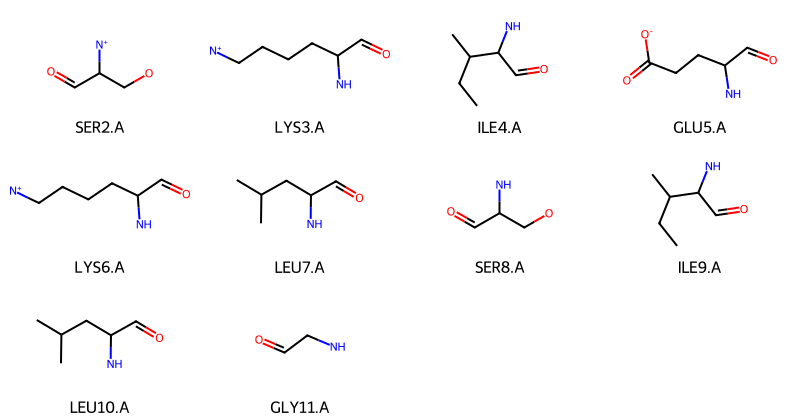

In [41]:
import prolif as plf

plf.display_residues(protein_mol, slice(0, 10), sanitize=False)

In [11]:
from prolif import sdf_supplier

ligands = []
for ligand_sdf in os.listdir(test_case_dir):  # noqa: PTH208
    if ligand_sdf.endswith("_protonated.sdf"):
        ligands.extend(sdf_supplier(f"{test_case_dir}/{ligand_sdf}"))

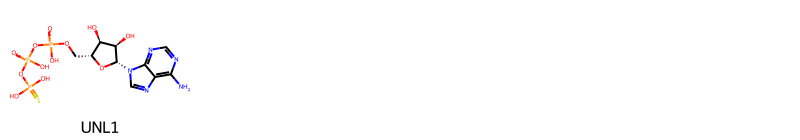

In [12]:
plf.display_residues(ligands[0])

In [13]:
ligands

[<prolif.molecule.Molecule with 1 residues and 47 atoms at 0x7faf8cecba10>,
 <prolif.molecule.Molecule with 1 residues and 1 atoms at 0x7faf8cfc7880>]

In [14]:
import warnings

warnings.filterwarnings("ignore")

dfs = []
fps = []
for each_ligand in ligands:
    fp = plf.Fingerprint(["HBDonor", "HBAcceptor"], count=True)
    fp.run_from_iterable([each_ligand], protein_mol, progress=False)
    df = fp.to_dataframe().T
    dfs.append(df)
    fps.append(fp)

In [15]:
dfs[0]

Frame                        0
ligand protein  interaction   
UNL1   ARG13.A  HBAcceptor   1
       ASN36.A  HBAcceptor   1
       GLY37.A  HBAcceptor   1
       GLY39.A  HBAcceptor   1
       LYS40.A  HBAcceptor   1
       THR41.A  HBAcceptor   1
       THR42.A  HBAcceptor   1
       ALA64.A  HBDonor      1
       ASP68.A  HBAcceptor   1
       GLN159.A HBAcceptor   1
       ARG431.A HBAcceptor   1
       GLY344.B HBAcceptor   1
       GLN345.B HBAcceptor   1

In [16]:
view = fps[0].plot_lignetwork(ligands[0], kind="frame", frame=0, display_all=False)
view

In [17]:
# Somtimes not working, need to check
view = fps[0].plot_3d(ligands[0], protein_mol, frame=0, display_all=True)
view

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Implicit

In [18]:
from prolif.molecule import Molecule

protein_mol_i = protein_helper.standardize_protein(
    Molecule.from_rdkit(Chem.RemoveAllHs(protein_mol))
)

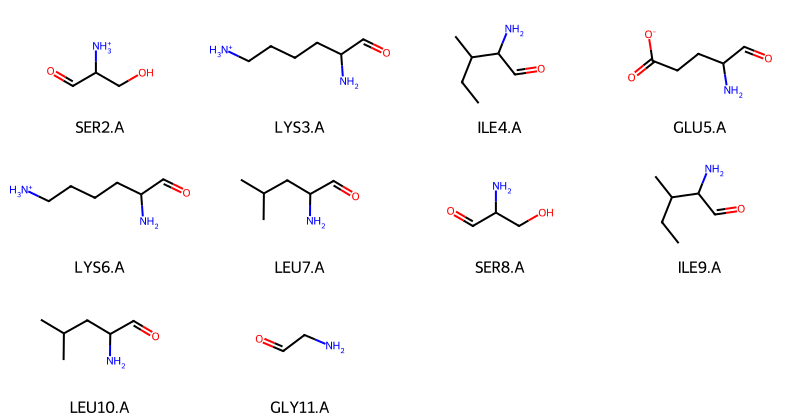

In [19]:
plf.display_residues(protein_mol_i, slice(0, 10), sanitize=False)

In [20]:
ligands_i = []
for ligand in ligands:
    ligands_i.append(Molecule.from_rdkit(Chem.RemoveAllHs(ligand)))

In [21]:
ligands_i

[<prolif.molecule.Molecule with 1 residues and 31 atoms at 0x7faf8cda3150>,
 <prolif.molecule.Molecule with 1 residues and 1 atoms at 0x7faf8cdee750>]

In [22]:
import warnings

warnings.filterwarnings("ignore")


dfs_i = []
fps_i = []
for each_ligand in ligands_i:
    fp = plf.Fingerprint(
        ["ImplicitHBDonor", "ImplicitHBAcceptor"],
        count=True,
        parameters={
            "ImplicitHBDonor": {
                "include_water": True,  # include water molecules
                "tolerance_dev_aaa": 50,  # angle deviation tolerance for acceptor atom
                "tolerance_dev_daa": 50,  # angle deviation tolerance for donor atom
                "tolerance_dev_dpa": 50,  # angle deviation tolerance for donor plane
                "tolerance_dev_apa": 90,  # angle deviation tolerance for acceptor plane
            },
            "ImplicitHBAcceptor": {
                "include_water": True,  # include water molecules
                "tolerance_dev_aaa": 50,  # angle deviation tolerance for acceptor atom
                "tolerance_dev_daa": 50,  # angle deviation tolerance for donor atom
                "tolerance_dev_dpa": 50,  # angle deviation tolerance for donor plane
                "tolerance_dev_apa": 90,  # angle deviation tolerance for acceptor plane
            },
        },
    )
    fp.run_from_iterable([each_ligand], protein_mol_i, progress=False)
    df = fp.to_dataframe().T
    dfs_i.append(df)
    fps_i.append(fp)

In [23]:
view = fps_i[0].plot_lignetwork(ligands_i[0], kind="frame", display_all=False)
view

In [24]:
view = fps_i[0].plot_3d(ligands_i[0], protein_mol_i, frame=0, display_all=True)
view.setStyle(
    {
        "resn": "HOH",
    },
    {"sphere": {"radius": 0.5, "color": "red"}},
)
view

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
from utils.metrics import (
    confusion_matrix,
    get_interactions,
    plot_confusion_matrix,
    tanimoto_coefficient_by_confusion_matrix,
)

In [26]:
matrices = []
tm_coefs = []
for df, df_i in zip(dfs, dfs_i, strict=False):
    explicit_set = get_interactions(df)
    implicit_set = get_interactions(df_i)

    matrix = confusion_matrix(explicit_set, implicit_set)
    tm_coef = tanimoto_coefficient_by_confusion_matrix(matrix)
    matrices.append(matrix)
    tm_coefs.append(tm_coef)

Tanimoto coefficient: 0.5652173913043478


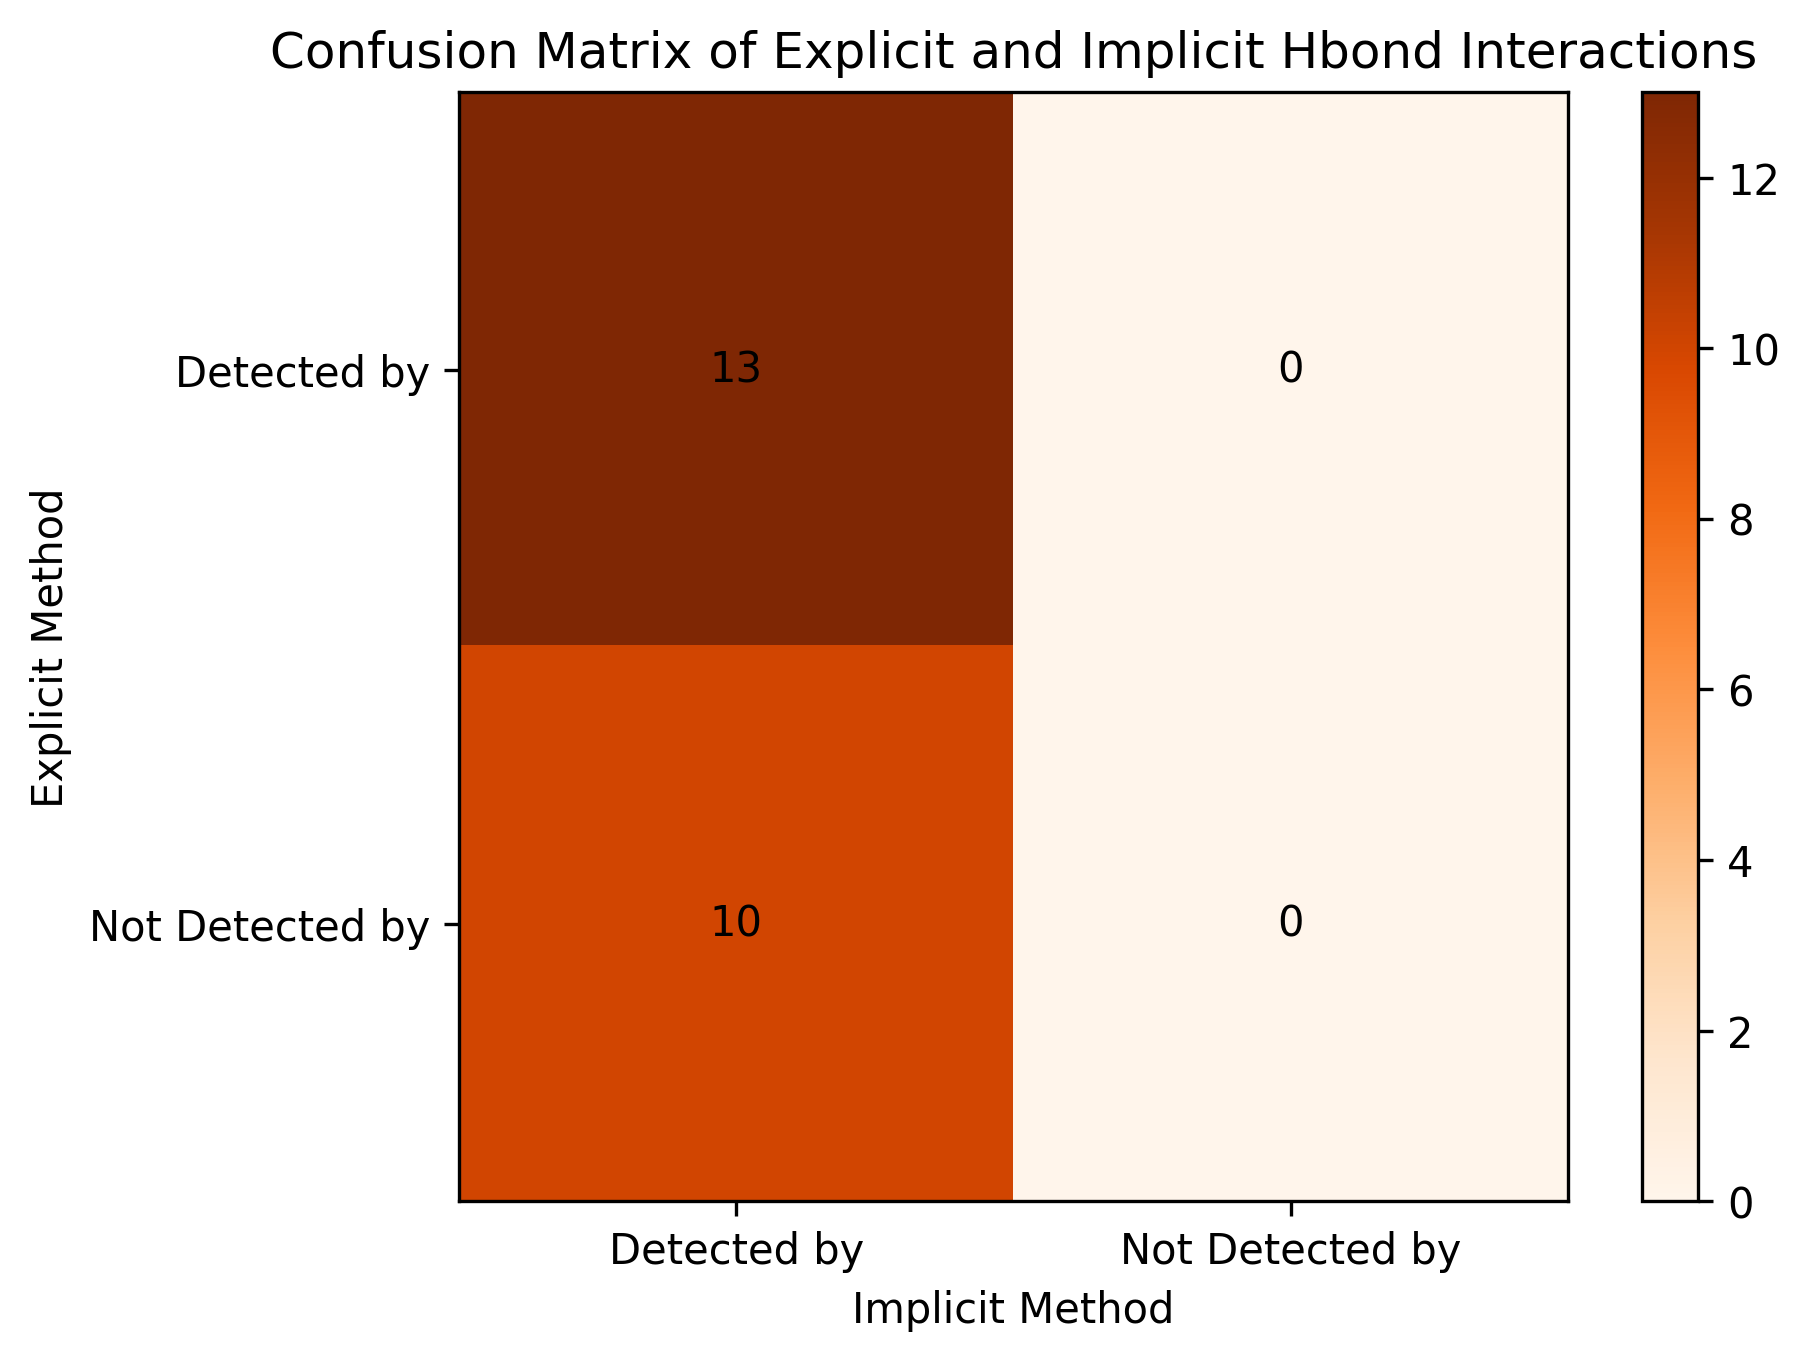

In [27]:
ligand_idx = 0

print("Tanimoto coefficient:", tm_coefs[ligand_idx])  # noqa: T201
fig, ax = plot_confusion_matrix(matrices[ligand_idx])
fig.show()

## Batch analysis

In [ ]:
import warnings

from tqdm import tqdm

warnings.filterwarnings("ignore")


dfs = []
fps = []
dfs_i = []
fps_i = []


for idx in tqdm(df_index.index):
    # Load explicit fingerprint
    if not os.path.exists(f"./val/explicit/fp_{idx}.pkl"):  # noqa: PTH110
        print(f"Explicit fingerprint for index {idx} not found, skipping.")  # noqa: T201
        continue
    if not os.path.exists(f"./val/implicit/fp_{idx}.pkl"):  # noqa: PTH110
        print(f"Implicit fingerprint for index {idx} not found, skipping.")  # noqa: T201
        continue
    fp = plf.Fingerprint.from_pickle(f"./val/explicit/fp_{idx}.pkl")
    df = fp.to_dataframe().T
    dfs.append(df)
    fps.append(fp)

    # Load implicit fingerprint
    fp = plf.Fingerprint.from_pickle(f"./val/implicit/fp_{idx}.pkl")
    df = fp.to_dataframe().T
    dfs_i.append(df)
    fps_i.append(fp)

    if idx == 2000:
        break

  5%|▌         | 60/1157 [00:00<00:03, 281.08it/s]

Implicit fingerprint for index 44 not found, skipping.


 14%|█▎        | 158/1157 [00:00<00:04, 242.76it/s]

Explicit fingerprint for index 114 not found, skipping.
Explicit fingerprint for index 147 not found, skipping.


 42%|████▏     | 483/1157 [00:01<00:02, 253.77it/s]

Explicit fingerprint for index 440 not found, skipping.


 48%|████▊     | 554/1157 [00:02<00:02, 296.48it/s]

Explicit fingerprint for index 512 not found, skipping.
Explicit fingerprint for index 513 not found, skipping.


 63%|██████▎   | 728/1157 [00:02<00:01, 321.27it/s]

Implicit fingerprint for index 672 not found, skipping.


 72%|███████▏  | 829/1157 [00:02<00:01, 322.50it/s]

Explicit fingerprint for index 817 not found, skipping.


 83%|████████▎ | 958/1157 [00:03<00:00, 256.32it/s]

Implicit fingerprint for index 904 not found, skipping.


 94%|█████████▍| 1089/1157 [00:03<00:00, 303.42it/s]

Explicit fingerprint for index 1049 not found, skipping.
Explicit fingerprint for index 1050 not found, skipping.
Implicit fingerprint for index 1072 not found, skipping.
Implicit fingerprint for index 1075 not found, skipping.
Implicit fingerprint for index 1078 not found, skipping.


100%|██████████| 1157/1157 [00:04<00:00, 277.10it/s]


In [34]:
len(dfs)

1143

In [ ]:
import numpy as np
from utils.metrics import get_interactions, tanimoto_coefficient
from utils.postprocess import get_metadata_from_implicit_hbond_using_set

# idx = 5
all_aaa_dev_list = []
all_daa_dev_list = []
all_dpa_list = []
all_apa_list = []

all_fp_aaa_dev_list = []
all_fp_daa_dev_list = []
all_fp_dpa_list = []
all_fp_apa_list = []


tm_coefs = []

for idx in range(len(dfs_i)):
    # Get the explicit interaction's implicit metadata
    explicit_set = get_interactions(dfs[idx])

    aaa_dev_list, daa_dev_list, dpa_list, apa_list = (
        get_metadata_from_implicit_hbond_using_set(explicit_set, fps_i[idx])
    )
    all_aaa_dev_list.extend(aaa_dev_list)
    all_daa_dev_list.extend(daa_dev_list)
    all_dpa_list.extend(dpa_list)
    all_apa_list.extend(apa_list)

    # Get the false positive interaction's implicit metadata
    implicit_set = get_interactions(dfs_i[idx])
    false_positive_set = implicit_set - explicit_set
    fp_aaa_dev_list, fp_daa_dev_list, fp_dpa_list, fp_apa_list = (
        get_metadata_from_implicit_hbond_using_set(false_positive_set, fps_i[idx])
    )
    all_fp_aaa_dev_list.extend(fp_aaa_dev_list)
    all_fp_daa_dev_list.extend(fp_daa_dev_list)
    all_fp_dpa_list.extend(fp_dpa_list)
    all_fp_apa_list.extend(fp_apa_list)

    # Calculate Tanimoto coefficient
    tm_coef = tanimoto_coefficient(explicit_set, implicit_set)
    tm_coefs.append(tm_coef)

print("Tanimoto coefficients:", np.mean(tm_coefs))  # noqa: T201

Tanimoto coefficients: 0.5651308649123679


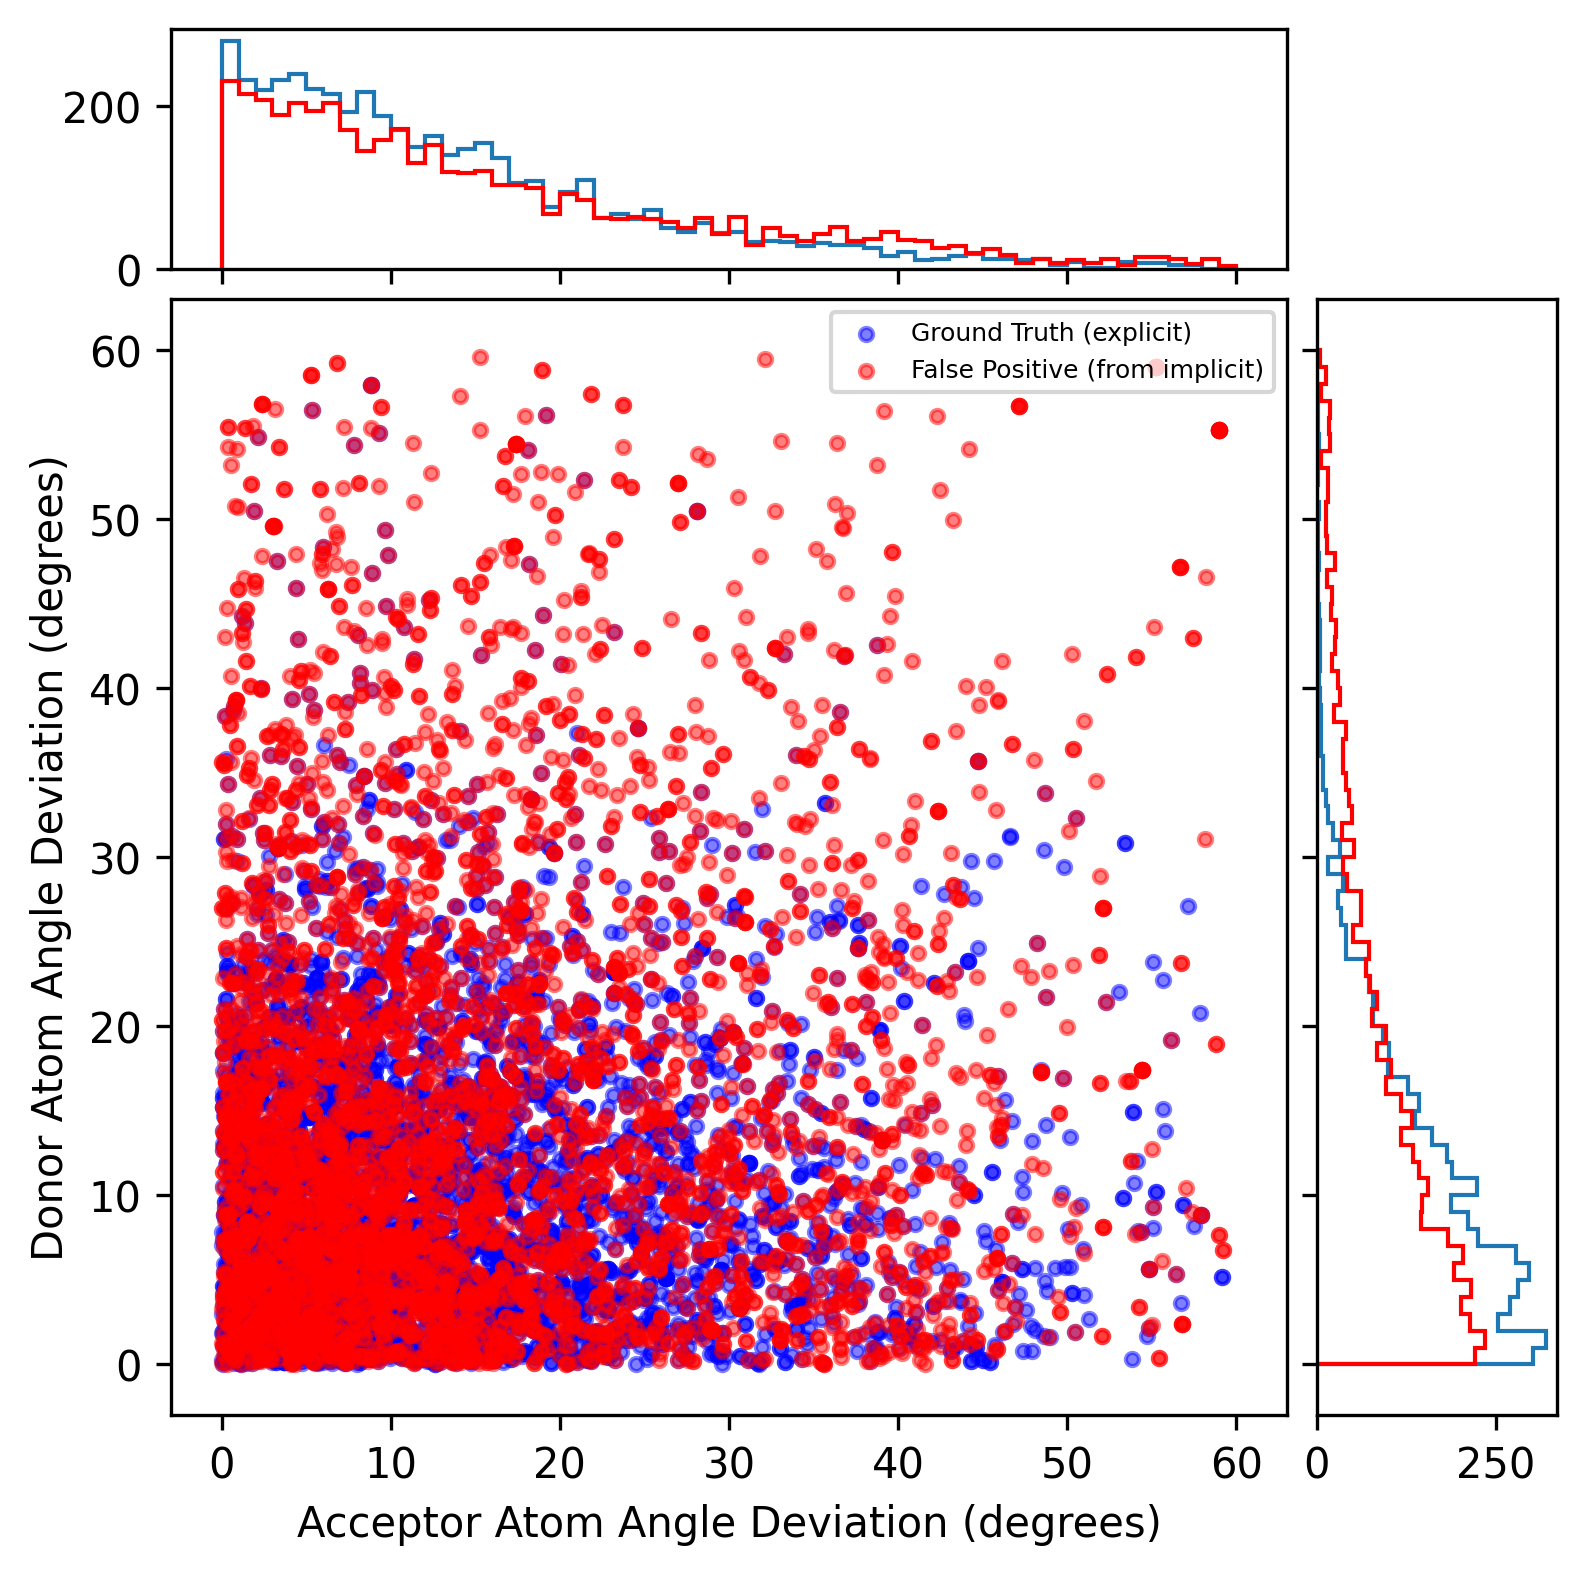

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(dpi=300, figsize=(8, 6))
ax.scatter(all_aaa_dev_list, all_daa_dev_list, s=10, alpha=0.5, c="blue")
ax.scatter(all_fp_aaa_dev_list, all_fp_daa_dev_list, s=10, alpha=0.5, c="red")


# the scatter plot:
# Set aspect of the main Axes.
ax.set_aspect(1.0)

# create new Axes on the right and on the top of the current Axes
divider = make_axes_locatable(ax)
# below height and pad are in inches
ax_histx = divider.append_axes("top", 0.8, pad=0.1, sharex=ax)
ax_histy = divider.append_axes("right", 0.8, pad=0.1, sharey=ax)

# make some labels invisible
ax_histx.xaxis.set_tick_params(labelbottom=False)
ax_histy.yaxis.set_tick_params(labelleft=False)

# now determine nice limits by hand:
binwidth = 1
xymax = max(np.max(np.abs(all_aaa_dev_list)), np.max(np.abs(all_daa_dev_list)))
lim = (int(xymax / binwidth) + 1) * binwidth

bins = np.arange(0, lim + binwidth, binwidth)
ax_histx.hist(all_aaa_dev_list, bins=bins, histtype="step")
ax_histx.hist(all_fp_aaa_dev_list, bins=bins, histtype="step", color="red")
ax_histy.hist(all_daa_dev_list, bins=bins, histtype="step", orientation="horizontal")
ax_histy.hist(
    all_fp_daa_dev_list,
    bins=bins,
    orientation="horizontal",
    histtype="step",
    color="red",
)

# the xaxis of ax_histx and yaxis of ax_histy are shared with ax,
# thus there is no need to manually adjust the xlim and ylim of these
# axis.

# ax_histx.set_yticks([0, 50, 100])
# ax_histy.set_xticks([0, 50, 100])

ax.set_xlabel("Acceptor Atom Angle Deviation (degrees)")
ax.set_ylabel("Donor Atom Angle Deviation (degrees)")
ax.legend(
    ["Ground Truth (explicit)", "False Positive (from implicit)"],
    loc="upper right",
    fontsize=6,
)
fig.show()

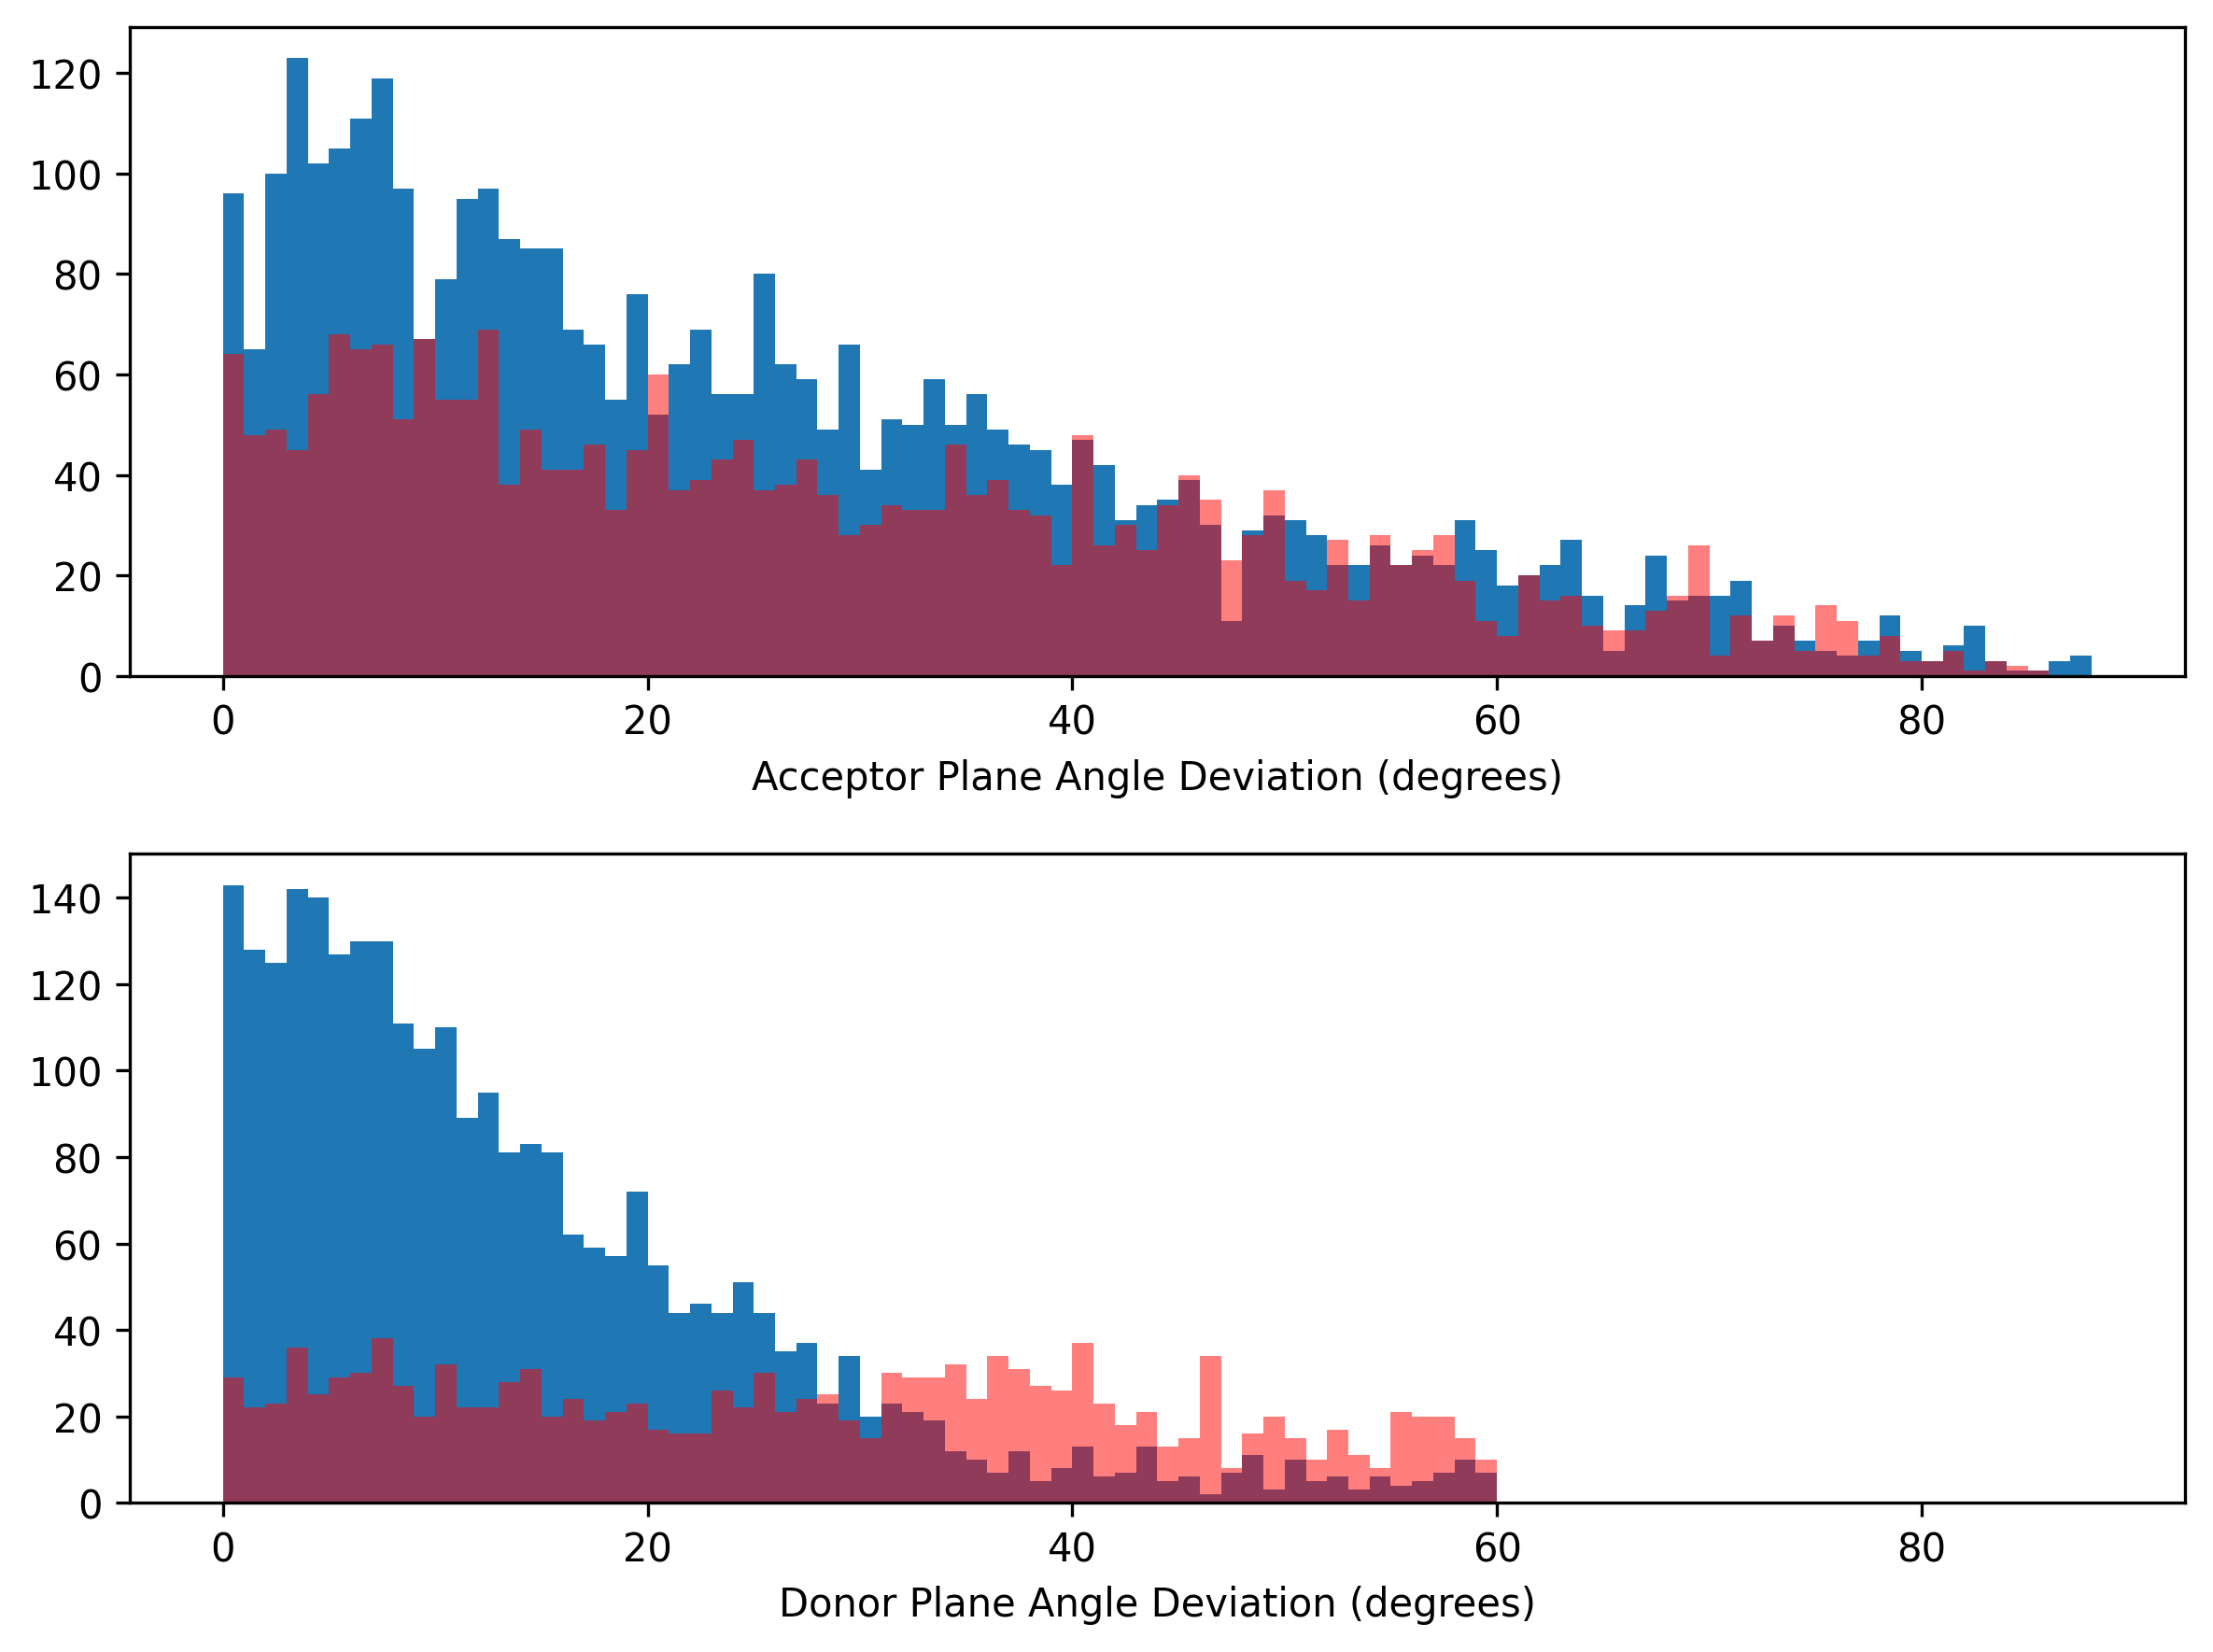

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(2, 1, dpi=300, figsize=(8, 6))

# now determine nice limits by hand:
binwidth = 1
xymax = max(
    np.max(np.abs(all_apa_list)),
    np.max(np.abs(all_dpa_list)),
    np.max(np.abs(all_fp_apa_list)),
    np.max(np.abs(all_fp_dpa_list)),
)
lim = (int(xymax / binwidth) + 1) * binwidth

bins = np.arange(0, lim + binwidth, binwidth)
ax[0].hist(all_apa_list, bins=bins)
ax[0].hist(all_fp_apa_list, bins=bins, alpha=0.5, color="red")
ax[1].hist(all_dpa_list, bins=bins)
ax[1].hist(all_fp_dpa_list, bins=bins, alpha=0.5, color="red")

ax[0].set_xlabel("Acceptor Plane Angle Deviation (degrees)")
ax[1].set_xlabel("Donor Plane Angle Deviation (degrees)")
fig.tight_layout()
fig.show()